In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# setup disply parameters
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
from matplotlib.ticker import StrMethodFormatter
float_formatter = StrMethodFormatter('{x:0.03f}')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', figsize=(18, 6)) # set figure size

In [2]:
from abc import abstractmethod, ABC
from dataclasses import dataclass, field
from random import random
from negmas import Mechanism, MechanismRoundResult, Negotiator, AspirationMixin
from negmas import MechanismState
from negmas import AgentMechanismInterface
from negmas import outcome_as_tuple
from typing import Callable, Tuple, Optional, List, Any, Dict
from negmas import Outcome, Issue, UtilityFunction, LinearUtilityFunction, ExpDiscountedUFun
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
import nashpy
import networkx as nx
import itertools
from random import sample
import random


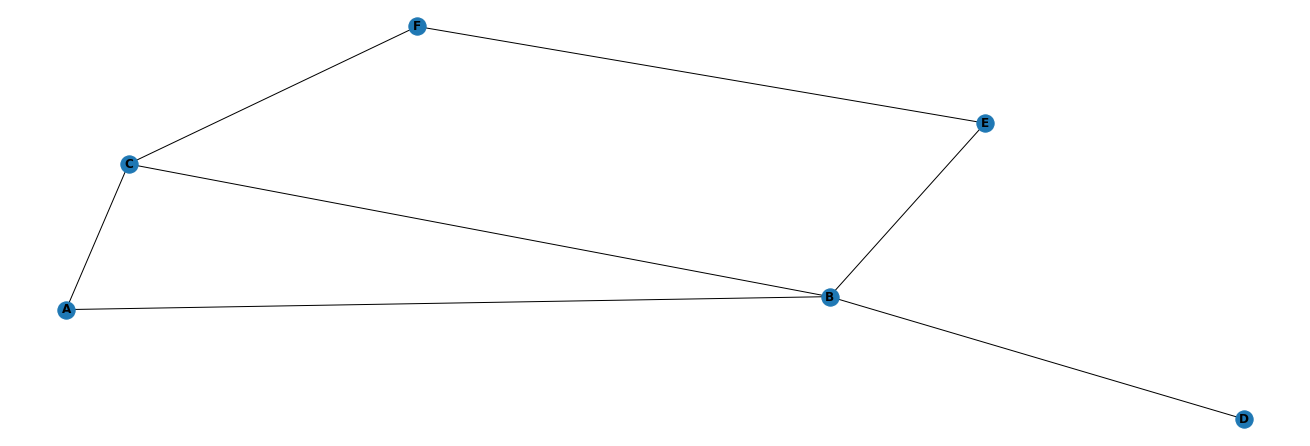

In [3]:
G = nx.Graph()

G.add_node('A') 
G.add_node('B') 
G.add_node('C') 
G.add_node('D') 
G.add_node('E') 
G.add_node('F') 


G.add_edge('A', 'B', weight=5)
G.add_edge('A', 'C' ,weight=7)
G.add_edge('B', 'C', weight=3)
G.add_edge('B', 'D', weight=10)
G.add_edge('B', 'E', weight=7)
G.add_edge('C', 'F', weight=8)
G.add_edge('E', 'F', weight=6)


nx.draw(G, with_labels=True, font_weight='bold')

In [4]:
class TaskOrientedDomainMechanism(Mechanism):

    def __init__(self,**kwargs):
        kwargs.update(dict(n_steps=10, max_n_agents=2, dynamic_entry=False))
        super().__init__(**kwargs)
        self.add_requirements(dict(propose_for_self = True))
        self.ufuns: List[UtilityFunction] = []

    def add(self,negotiator: "Negotiator",*,ufun: Optional["UtilityFunction"] = None,**kwargs,) -> Optional[bool]:
        added = super().add(negotiator, ufun=ufun, role=None, **kwargs)
        if added:
            self.ufuns.append(self.negotiators[-1].utility_function)

    def is_feasible(self, outcome):    
        total = sorted(list(set().union(self.negotiators[0].tasks,self.negotiators[1].tasks)))
        return (sum(1 for c in total if (c in outcome[0]) or (c in outcome[1]))) == len(total) and 
                sum(1 for c in total if (c in outcome[0]) and (c in outcome[1]) and c!='A') == 0
    

    def round(self)-> MechanismRoundResult:
        if len(self.negotiators) != 2:
            return MechanismRoundResult(error=True,
                                        error_details=f"Got {len(self.negotiators)} negotiators!!",
                                        broken=True)
        
        outcome = tuple(n.propose_for_self(self.ufuns, i) for i, n in enumerate(self.negotiators))
        
        if self.is_feasible(outcome):                                                                          
            return MechanismRoundResult(agreement=outcome)
        
        
        return MechanismRoundResult()

In [5]:
class CostOfTasks(UtilityFunction):
    
    def __init__(self, tasks,graph):
        super().__init__()
        self.tasks = tasks
        self.tasks.insert(len(self.tasks),'A')
        self.G = graph
    
    def __call__(self, offer):
        return self.Utility_value(self.tasks) - self.Utility_value(offer)
        
    def Utility_value(self,tasks):
        return sum(nx.dijkstra_path_length(self.G, tasks[i],  tasks[i+1]) for i in range(len(tasks)-1))
        
    def xml(self):
        pass

In [6]:
class TODNegotiatior(Negotiator):

    def __init__(self, index, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.add_capabilities(dict(propose_for_self=True))
        self.index = index
        self.other = 1 if self.index==0 else 0
        
    def set_tasks(self,tasks, total_tasks):
        self.tasks = tasks
        self.total_tasks = total_tasks

    def propose_for_self(self, ufuns: List[UtilityFunction], my_indx: int) -> List[int]:
                
        best_objective = -np.inf
        best_f0_f1 = 0
            
        a = [itertools.permutations(self.total_tasks, i) for i in range(1,len(self.total_tasks)+1)]
        offers = [list(j) for i in a for j in i]
        
        for off in offers:
            
            
            f0 = off
            f1 = list(set(self.total_tasks) - set(f0))
            
            f0.insert(0,'A')
            f1.insert(0,'A')
            
            f0 = (list(dict.fromkeys(f0)))
            f1 = (list(dict.fromkeys(f1)))
            
            #UNCOMMENT IF THEY HAVE TO COMEBACK
            #f0.insert(len(f0),'A')
            #f1.insert(len(f1),'A')

            objective = ufuns[0](f0) * ufuns[1](f1)
            
            if objective >= best_objective:
                best_objective = objective
                best_f0_f1 = (f0,f1)
            
                
        #return best_f0_f1
        return best_f0_f1[self.index]

    
    

Outcome: (['A', 'C', 'F', 'E'], ['A', 'B', 'D'])
Agreement: (['A', 'C', 'F', 'E'], ['A', 'B', 'D'])


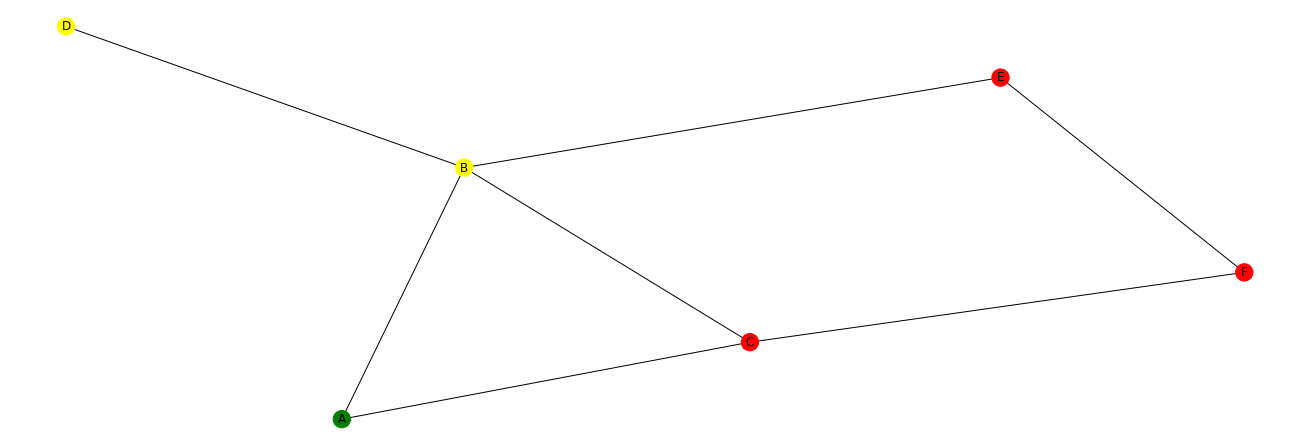

In [7]:
G = nx.Graph()

G.add_node('A') 
G.add_node('B') 
G.add_node('C') 
G.add_node('D') 
G.add_node('E') 
G.add_node('F') 


G.add_edge('A', 'B', weight=5)
G.add_edge('A', 'C' ,weight=8)
G.add_edge('B', 'C', weight=9)
G.add_edge('B', 'D', weight=10)
G.add_edge('B', 'E', weight=7)
G.add_edge('C', 'F', weight=8)
G.add_edge('E', 'F', weight=6)


#T1 = ['A','C','E']
#T2 = ['A','C','B','D','F']

T1 = ['A','C','F','E']
T2 = ['A','C','B','D']

total_tasks = sorted(list(set().union(T1,T2)))


u1 = CostOfTasks(T1,G)
u2 = CostOfTasks(T2,G)

m = TaskOrientedDomainMechanism()

a1 = TODNegotiatior(0,ufun=u1, name="a1" )
a1.set_tasks(T1,total_tasks)
m.add(a1)

a2 = TODNegotiatior(1,ufun=u2, name="a2" )
a2.set_tasks(T2,total_tasks)
m.add(a2)

result = m.run()
print(f"Agreement: {result.agreement}")

color_map = []
for node in G:
    if node in result.agreement[0] and node != 'A':
        color_map.append('red')
    elif node != 'A': 
        color_map.append('yellow') 
    if node == 'A':
        color_map.append('green')
        
    
nx.draw(G, node_color=color_map, with_labels=True)
plt.show()

# ESCENARIO 2

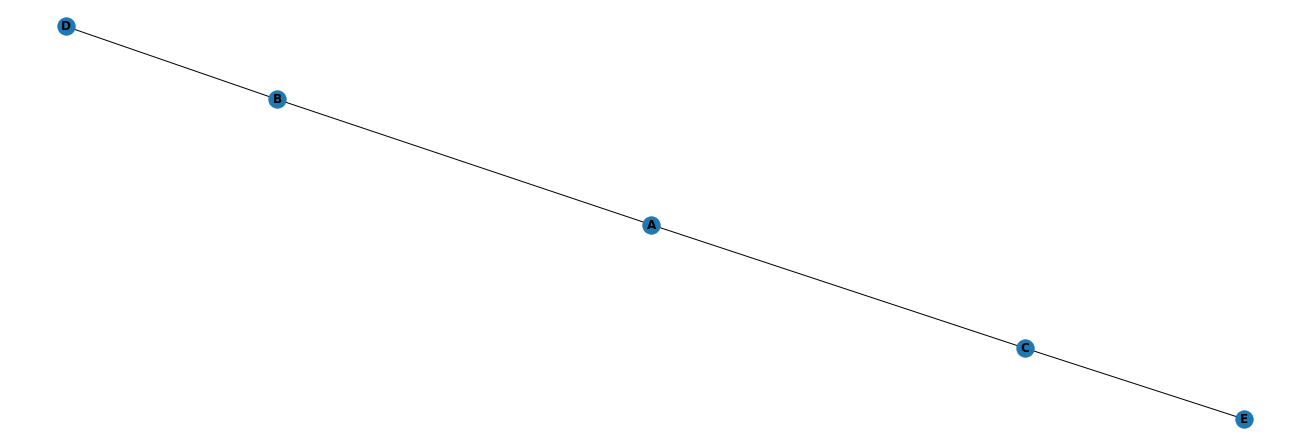

In [8]:
G2 = nx.Graph()

G2.add_node('A') 
G2.add_node('B') 
G2.add_node('C') 
G2.add_node('D') 
G2.add_node('E')  


G2.add_edge('A', 'B', weight=5)
G2.add_edge('A', 'C' ,weight=5)
G2.add_edge('B', 'D', weight=15)
G2.add_edge('C', 'E', weight=15)


nx.draw(G2, with_labels=True, font_weight='bold')

Outcome: (['A', 'C', 'E'], ['A', 'B', 'D'])
Agreement: (['A', 'C', 'E'], ['A', 'B', 'D'])


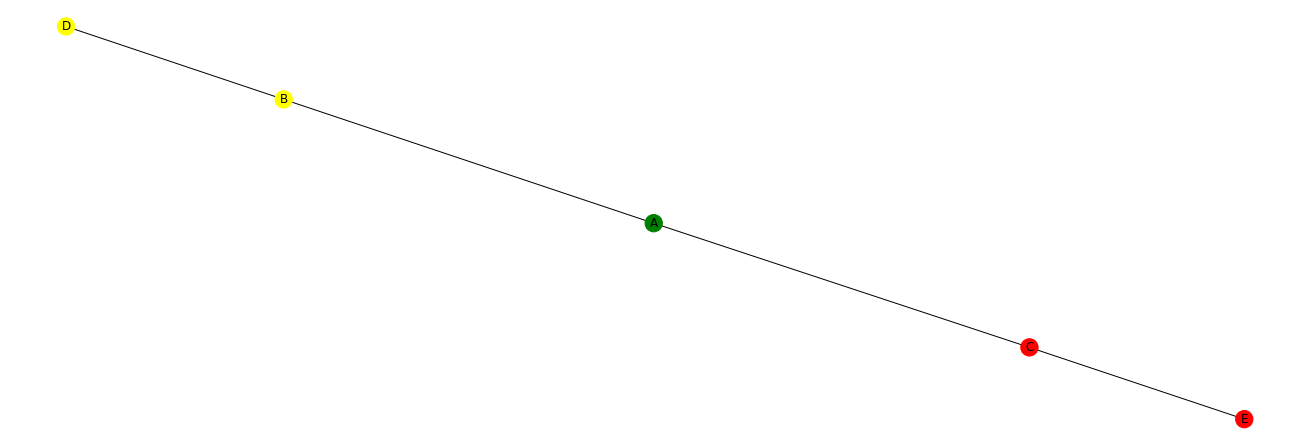

In [13]:
T1_ = ['A','B','D','E']
T2_ = ['A','C','E']


total_tasks = sorted(list(set().union(T1_,T2_)))

u1_ = CostOfTasks(T1_,G2)
u2_ = CostOfTasks(T2_,G2)

m2 = TaskOrientedDomainMechanism()

b1 = TODNegotiatior(0,ufun=u1_, name="b1" )
b1.set_tasks(T1_,total_tasks)
m2.add(b1)

b2 = TODNegotiatior(1,ufun=u2_, name="b2" )
b2.set_tasks(T2_,total_tasks)
m2.add(b2)


result = m2.run()
print(f"Agreement: {result.agreement}")


    
color_map = []
for node in G2:
    if node in result.agreement[0] and node != 'A':
        color_map.append('red')
    elif node != 'A': 
        color_map.append('yellow') 
    if node == 'A':
        color_map.append('green')
        
    
nx.draw(G2, node_color=color_map, with_labels=True)
plt.show()